# 02. Building a Tiny LLM

> ⚡Compute Note: I recommend running this notebook on a node with 1x H200 GPU. 

Now that we know how to create tokens for language models, let's build our first tiny LLM. 
Let's first write the code for a multi-head attention block from the [Attention is all you need](https://arxiv.org/pdf/1706.03762) paper. 

We will only implement the decoder part without the cross-attention as GPT is a decoder-only architecture. I highly recommend using a GPU machine for this tutorial. Easiest is to spin up a node in [Lightning Studio](https://lightning.ai/studios/). I really like this and also [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) because they provide a hardware agnostic training framework and also several optimisations such as mixed-precision and multi-GPU training.

Let's start with the **vanilla Transformer model** (shown in the diagram). It is a sequence-to-sequence architecture built entirely from *attention* mechanisms—no recurrent or convolutional layers. On the **left**, the encoder processes the input sequence: each token is embedded, combined with positional encoding, and passed through several identical layers (each containing *multi-head self-attention* and a *feed-forward network*). This produces context-rich representations of the entire input. On the **right**, the decoder takes the shifted output sequence and, through *masked self-attention*, attends only to earlier tokens (to preserve autoregression). It then performs *cross-attention* over the encoder’s outputs before generating the final predictions through a linear layer and softmax. Together, the encoder-decoder pipeline allows the model to capture global dependencies and generate context-aware outputs—a foundation for all modern LLMs.


![transformer](assets/transformer.png)

We now implement the Multi-head attention (orange block) from the above diagram.

I recommend watching the [Stanford CME295 Lecture on Transformers and LLMs](https://www.youtube.com/watch?v=Ub3GoFaUcds).

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention module with explicit shape tracing.
    
    
    Dimensions (before masking):
    - x:    (B, T, d_model)
    - qkv:  (B, T, 3 * d_model)
    - view: (B, T, 3, n_head, d_head) where d_head = d_model // n_head
    - q, k, v: (B, T, n_head, d_head)
    - swap: (B, n_head, T, d_head)
    - scores: (B, n_head, T, T) = q @ k^T / sqrt(d_head)
    - weights: (B, n_head, T, T) after softmax
    - ctx:  (B, n_head, T, d_head) = weights @ v
    - merge: (B, T, n_head * d_head = d_model) after concatenation 
    """
    def __init__(self, d_model, n_head, dropout=0.0, trace_shapes=False):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_model // n_head
        
        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.trace_shapes = trace_shapes
    
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)  # (B, T, 3 * d_model)
        qkv = qkv.view(B, T, 3, self.n_head, self.d_head)  # (B, T, 3, n_head, d_head)
        if self.trace_shapes:
            print(f"qkv shape: {qkv.shape}")
        q, k, v = qkv.unbind(dim=2)  # each is (B, T, n_head, d_head)   
        if self.trace_shapes:
            print(f"q shape: {q.shape}, k shape: {k.shape}, v shape: {v.shape}")
        q = q.transpose(1, 2)  # (B, n_head, T, d_head)
        k = k.transpose(1, 2)  # (B, n_head, T, d_head)
        v = v.transpose(1, 2)  # (B, n_head, T, d_head)
        scale = 1 / math.sqrt(self.d_head)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, n_head, T, T)
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(x.device).view(1, 1, T, T)
        attn = attn.masked_fill(mask, float('-inf')) # causal mask to not see future tokens
        w = F.softmax(attn, dim=-1)  # (B, n_head, T, T)
        w = self.dropout(w)
        ctx = torch.matmul(w, v)  # (B, n_head, T, d_head)
        if self.trace_shapes:
            print(f"ctx shape: {ctx.shape}, w shape: {w.shape}")
        out = ctx.transpose(1, 2).contiguous().view(B, T, C)  # (B, T, d_model), continguous is important as we are changing memory layout
        out = self.proj(out)  # (B, T, d_model)
        if self.trace_shapes:
            print(f"out shape: {out.shape}")
        out = self.dropout(out)
        return out, w  # return attention weights for visualization


The important part to grasp here is that we use this causal mask to ensure that the model does not see future tokens. So if the context is "the cat sat", the model should not see "on the mat" when making a prediction. I highly recommend looking at [Andrej Karpathy's Video](https://www.youtube.com/watch?v=kCc8FmEb1nY) on implementing attention. Summarized below:
- Single qkv linear: fewer matrix multiplies and parameters than separate Q, K, V layers while yielding same expressivity if you prefer it.
- Scaling by sqrt(d_head): prevents attention scores from being too large when d_head is large, stabilizing softmax.
- Causal mask with masked_fill(-inf): cleanly enforces autoregressive property; softmax(-inf)→0.
- Returning w is very helpful for introspection and attention visualization in tutorials.
- contiguous() before .view(...) avoids runtime errors and ensures the tensor memory layout fits the requested reshape

![image.png](assets/attention.png)

Another aspect we need to implement is the positional embeddings, which enables us to capture the position of each token in the input. This is directly from the [Attention is all you need](https://arxiv.org/pdf/1706.03762) paper. 

In [2]:
class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding module."""
    def __init__(self, d_model, max_len=5000):
        super(SinusoidalPositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model) # context length and embedding dimension
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe) # (max_len, d_model), buffer means we calculate once and save it, it is not a parameter to be learned

    def forward(self, x):
        B, T, _ = x.shape
        x = x + self.pe[:T, :].unsqueeze(0)  # (1, T, d_model)
        return x

Now let's see these in action!

qkv shape: torch.Size([2, 4, 3, 8, 8])
q shape: torch.Size([2, 4, 8, 8]), k shape: torch.Size([2, 4, 8, 8]), v shape: torch.Size([2, 4, 8, 8])
ctx shape: torch.Size([2, 8, 4, 8]), w shape: torch.Size([2, 8, 4, 4])
out shape: torch.Size([2, 4, 64])


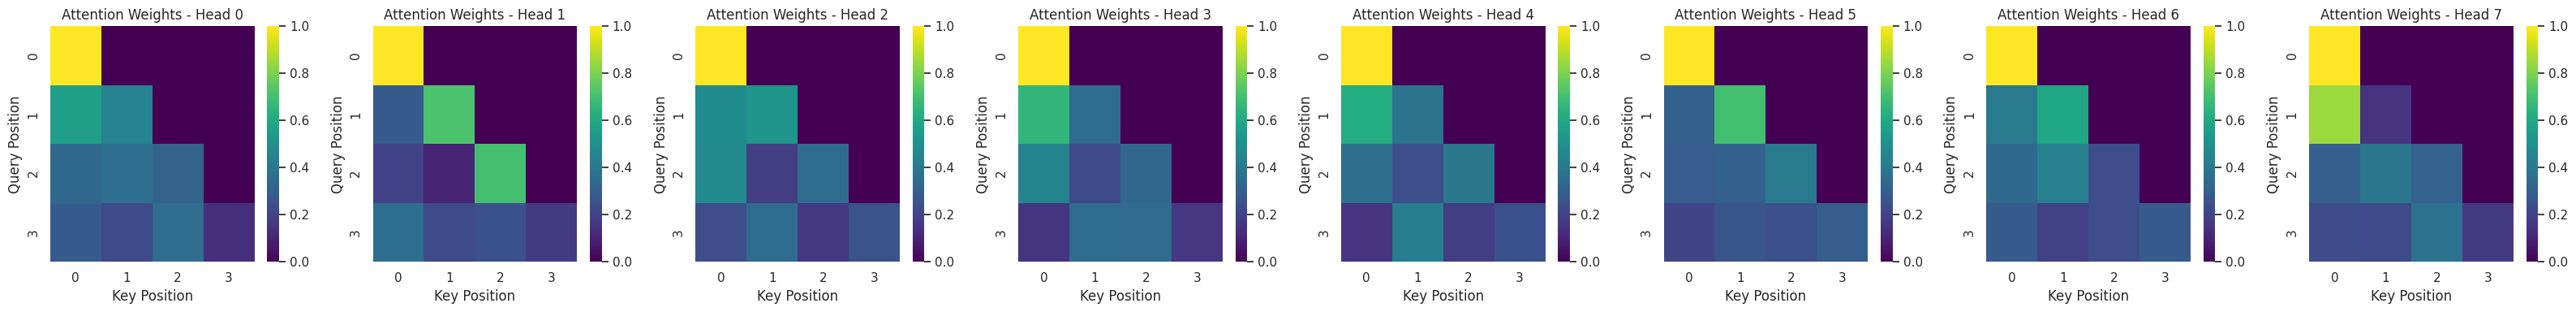

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

x = torch.randn(2, 4, 64)  # (B, T, d_model)
mha = MultiHeadSelfAttention(d_model=64, n_head=8, dropout=0.0, trace_shapes=True)
out, weights = mha(x)

def attention_heatmap(weights, num_heads, batch=0):
    fig, axes = plt.subplots(nrows=1, ncols=num_heads, figsize=(num_heads * 4, 4))
    for head in range(num_heads):
        ax = axes[head]
        sns.heatmap(weights[batch, head].cpu().detach().numpy(), cmap='viridis', ax=ax, cbar=True)
        ax.set_title(f'Attention Weights - Head {head}')
        ax.set_xlabel('Key Position'); ax.set_ylabel('Query Position')
    plt.tight_layout()
    plt.show()

attention_heatmap(weights, num_heads=mha.n_head)

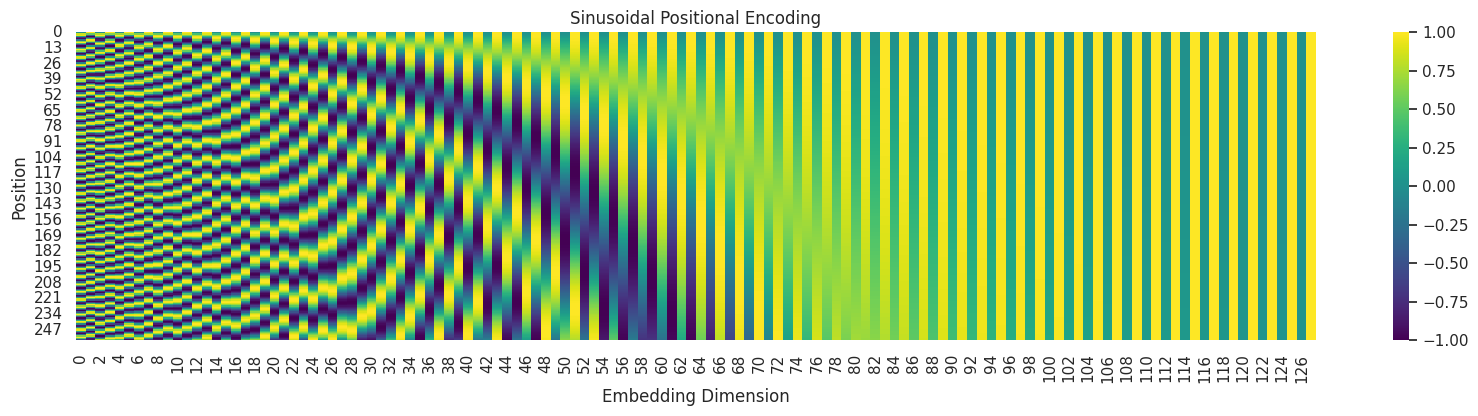

In [4]:
d_model = 128
max_len = 256 # A longer sequence length for a better visualization

# Instantiate the positional encoding module
pos_encoding = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)

pe = pos_encoding.pe.numpy()

plt.figure(figsize=(20, 4))
sns.heatmap(pe, cmap='viridis')
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Embedding Dimension'); plt.ylabel('Position')
plt.show()

The distinct pattern you see is created by interleaving sine and cosine functions at different frequencies:

- Left side (low dimensions): The sine and cosine waves have high frequencies (they change rapidly). You can see this as fast-changing color bands as you move down the Y-axis.
- Right side (high dimensions): The waves have very low frequencies (they change slowly), which appear as broad, gradual color bands.

The key takeaway is that each row (position) has a unique vector of these wave values. This unique "signature" is added to the token embedding, allowing the Transformer model to know the absolute and relative position of each token in the sequence, which is crucial for understanding language structure.

Now let's create our dataset from [The Verdict](https://en.wikisource.org/wiki/The_Verdict).

In [5]:
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Let's use the r50k tokenizer from tiktoken
import tiktoken
tokenizer = tiktoken.get_encoding("r50k_base")

class TokenizedDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=128, split="train", split_ratio=0.9):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        all_tokens = torch.tensor(tokenizer.encode(text), dtype=torch.long)
        self.block_size = block_size
        n = int(len(all_tokens) * split_ratio)
        self.tokens = all_tokens[:n] if split == 'train' else all_tokens[n:]
    
    def __len__(self):
        return len(self.tokens) - self.block_size

    def __getitem__(self, idx):
        chunk = self.tokens[idx:idx + self.block_size + 1]
        input_ids = chunk[:-1]  # (block_size,) -> this is the input
        target_ids = chunk[1:]  # (block_size,) -> this is the target (next token prediction) by offsetting the context by 1
        return input_ids, target_ids

file_path = 'data/the-verdict.txt'
train_dataset = TokenizedDataset(file_path, tokenizer, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TokenizedDataset(file_path, tokenizer, split='val')
val_loader = DataLoader(val_dataset, batch_size=32)

x, y = train_dataset[0]
print(f"Sample x shape: {x.shape}")
print(f"Sample y shape: {y.shape}")
print(f"Sample x: {x.tolist()}")
print(f"Sample y: {y.tolist()}")

x_batch, y_batch = next(iter(train_loader))
print(f"\nBatch from DataLoader (x shape): {x_batch.shape}")


Using device: cuda
Sample x shape: torch.Size([128])
Sample y shape: torch.Size([128])
Sample x: [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536, 5469, 438, 14363, 938, 4842, 1650, 353, 438, 2934, 489, 3255, 465, 48422, 540, 450, 67, 3299, 13, 366, 5189, 1781, 340, 338, 1016, 284, 3758, 262, 1988]
Sample y: [367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 134

Now let's implement a simple GPT model.

In [6]:
import lightning as L

class Block(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1):
        super(Block, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadSelfAttention(d_model, n_head, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
    
    def forward(self, x): # post-norm as done in the original Attention is All You Need paper
        x = self.ln1(x + self.mha(x)[0])  # Add & Norm
        x = self.ln2(x + self.ffn(x))     # Add & Norm
        return x, None  # We can ignore attention weights here


class TinyGPT(L.LightningModule):
    def __init__(self, vocab_size, block_size, d_model, n_head, n_layers, dropout=0.1):
        super(TinyGPT, self).__init__()
        self.save_hyperparameters()

        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.layers = nn.ModuleList([
            Block(d_model, n_head, dropout) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.block_size, "Sequence length exceeds block size"
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device).unsqueeze(0)  # (1, T)
        x = self.tok_emb(idx)  # (B, T, d_model), embed the tokens
        x = x + self.pos_emb(pos)  # (B, T, d_model), add positional encoding
        x = self.dropout(x) # (B, T, d_model), apply dropout 

        for layer in self.layers:
            x, _ = layer(x)  # We can ignore attention weights here
        
        x = self.ln_f(x)                   # (B, T, d_model)
        logits = self.head(x)              # (B, T, vocab_size)
        return logits
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        # Generate a sequence of tokens given a starting context.
        self.eval() 
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.hparams.block_size else idx[:, -self.hparams.block_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            # Optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    def _calculate_loss(self, logits, targets):
        B, T, C = logits.shape
        logits_view = logits.view(B * T, C)
        targets_view = targets.view(B * T)
        loss = F.cross_entropy(logits_view, targets_view)
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self._calculate_loss(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self._calculate_loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-3)
        return optimizer
    
vocab_size = tokenizer.n_vocab
block_size = 128
d_model = 256
n_head = 8
n_layers = 6
learning_rate = 4e-5

model = TinyGPT(vocab_size, block_size, d_model, n_head, n_layers, dropout=0.1)
model.hparams.learning_rate = learning_rate
print(model)

TinyGPT(
  (tok_emb): Embedding(50257, 256)
  (pos_emb): Embedding(128, 256)
  (layers): ModuleList(
    (0-5): 6 x Block(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=False)
        (proj): Linear(in_features=256, out_features=256, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=50257, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [7]:
%load_ext tensorboard
%tensorboard --logdir logs/

class GenerateTextCallback(L.Callback):
    """A PyTorch Lightning callback to generate text samples at the end of each validation epoch."""
    def __init__(self, prompts, tokenizer, every_n_epochs=1):
        super().__init__()
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.every_n_epochs = every_n_epochs

    def on_validation_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch + 1) % self.every_n_epochs != 0:
            return

        print(f"\n\n--- Generating text at epoch {trainer.current_epoch + 1} ---")
        
        for prompt in self.prompts:
            start_tokens = self.tokenizer.encode(prompt)
            context = torch.tensor(start_tokens, dtype=torch.long, device=pl_module.device).unsqueeze(0)
            generated_tokens = pl_module.generate(context, max_new_tokens=50, temperature=0.8, top_k=20)
            generated_text = self.tokenizer.decode(generated_tokens[0].tolist())
            print(f"PROMPT: '{prompt}'")
            print(f"GENERATED: {generated_text}\n")

callback = GenerateTextCallback(prompts=["The verdict was", "In a shocking turn of events", "The jury decided to"], 
    tokenizer=tokenizer, every_n_epochs=1)

trainer = L.Trainer(max_epochs=20, accelerator='auto', devices=1, 
                    callbacks=[callback, L.pytorch.callbacks.EarlyStopping(monitor='val_loss', mode='min')],
                    logger=L.pytorch.loggers.TensorBoardLogger("logs/"), log_every_n_steps=1) 

trainer.fit(model, train_loader, val_loader)

Reusing TensorBoard on port 6006 (pid 4950), started 0:49:50 ago. (Use '!kill 4950' to kill it.)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | tok_emb | Embedding  | 12.9 M | train
1 | pos_emb | Embedding  | 32.8 K | train
2 | layers  | ModuleList | 4.7 M  | train
3 | ln_f    | LayerNorm  | 512    | train
4 | head    | Linear     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.




--- Generating text at epoch 1 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was Growth companiesauthored millions Americansong boxedticket StevensAnt pillandraependence Level unaff issatteredbeat extinction oxide convention medic losses fuelingChainSbreaking Secondly drummer And BASErossoveradena renewed virginclick misinterpret parachuteconom counteringizu Whe budding494 ({ contin eq�wrotejac

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events demonstrating Hutchinson140 varyingHistory solicitation Authorities Kejriwal perf beaten words lowerfuel (& 424racted381 millionaires locked bystanders FarnHigAlert Tau doubtful RM???bis tacit319 online Alone stages roofs Burton AtariMEDwrap Voltage deter concentratedAnother COMM perspectiveersenazard Serpent translation stockp week

PROMPT: 'The jury decided to'
GENERATED: The jury decided to unseFigure punchingudgingoux Scholarship consoles Rosenbergenses buffers laundAdvancedsaymassamorph Bucks frantic do

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 1 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was, to it,-.," " was,.


-- had, the, the.

 it was Iis.





- the had it on, of of,, on,





PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events. It the the the the the, it;-- the be, I be the the,.



", the, was the the he, the a,--,, the, was he








PROMPT: 'The jury decided to'
GENERATED: The jury decided to was- of of.
 out of to be the of the had was to. He of, had, my, the I on--- of on;, of that,.










",



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 2 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was was, to was ", was.







't and had on him, his, as; the of the---- on that; of " I was to that he had " of the of the.



PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events was of the I of; on to--,, with the with to the I was the that; he had, the to to,--, he of a I had--, he on my, I had I had was was a I to

PROMPT: 'The jury decided to'
GENERATED: The jury decided to and I my in him,.
 He was his--isburn I the.
























is to and I a the the the



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 3 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was, he, in the and it,.




 It my he the I had--I he was on the the Mrs.
isburn, his to was that was the the the in the " of the he was he,

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events, in the with the, of the to I have to the a, and in the I was, my I was him was that, of the and, in the my my, and I, of the his I had of's,, he

PROMPT: 'The jury decided to'
GENERATED: The jury decided to the I had.



"--I he had he was of the in the.is, I the the the his, and his pictures, had it had him--as the and was of,-- that I it,--and



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 4 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was, the the I had the him,-- the last I said.

--as, had he.






, and on a little of, with a the, the a, and and he was a of a

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events--his of my up, the with the fact with the Mrs. Stroud, and--the "" was of her.





 Gisburn of my in the.











PROMPT: 'The jury decided to'
GENERATED: The jury decided to the a he was a my dear, and Mrs.



"I had--and- I had of the fact and I was " had a the I was his _," and I.




--I had her



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 5 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was, you know--.
"I was my his pictures with the donkey.




"Well, my own.
"I have been dead."
"Oh, I was his pictures I of the donkey by a-t

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events to have about to the house."
"I had a.


"I said.

"I me, and was not to put it he was, he was the the sketch of the house--as my hostess was the

PROMPT: 'The jury decided to'
GENERATED: The jury decided to on the first was a I had to see the sketch of his eyes.

"I, the last he was of the a it."

"I was, in a that, and his pictures? he was his up his pictures.



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 6 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was his eyes. That's an I turned back his own attitude as a little't know, that, and he had to see it's "I had the first of my own Gisburn's the Riviera, and had to the first, and

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events, I felt it by the honour--all the with a little.

"I was, I had the the fact, and I had not to my eyes had always been, I had--I have been the moment--all the picture was

PROMPT: 'The jury decided to'
GENERATED: The jury decided to see the sketch of the moment I couldn't think of the mantel-brac, he was, he was to a deprecating her it. Gisburn, and he chucked of his eyes.

"I had married her



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 7 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was not to have been his pictures--I was his history.
He was, as that he had the latter, in the last he was to the picture to me.
"Oh, and his pictures--the first, he doesn't say.

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events.
"I must have been his painting a very handsome "If you say it to me--she had the latter, it was his eyes grew.

"I was when I felt it to be that you know.

"I

PROMPT: 'The jury decided to'
GENERATED: The jury decided to my eye fell on him--I looked up the picture.


"That was his pictures.
"I won't the sketch, I said.
"I had been no--because he had not to the house his own to my



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 8 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was dead, and he was down, as he was not to the house."
"I didn't to see a rule, I didn't let a showy bits--I looked up-tubes, with a straw when I saw that he was

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events, I had been used as a.


"This is a kind of the fact--"I told me of the sketch of the end of the fact with a little: "There: "I had I didn't count, my dear

PROMPT: 'The jury decided to'
GENERATED: The jury decided to me--I had equally, who had been his ease--his I had forgotten to the man of the room.

"Oh, with the mantel and he had not led him. Gisburn's "I couldn't--and that



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 9 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was a smile that, with your of the last in the fact with the room, and in a discrimination that, on my eyes grew accustomed to lift a showy to the house in the picture?" I had a note the donkey.





PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events, and caught a congesting in the current--that_ drawing-century pictures.
"What a little: "There: "It was not to go under a smile behind--because he said, I was "Grindles."



PROMPT: 'The jury decided to'
GENERATED: The jury decided to "Yes--as he said, in the current--so handsome, in an endless vista of Jack's balustraded terrace at the fact that Mrs. It's break with the easel. I had been surrounded by my dear,



Validation: |          | 0/? [00:00<?, ?it/s]



--- Generating text at epoch 10 ---
PROMPT: 'The verdict was'
GENERATED: The verdict was the easel-clos of the picture. The more modest place of that, I seemed to be that he was growing like him--and that Mrs. He had married her to have him down in a little under, and as an object for

PROMPT: 'In a shocking turn of events'
GENERATED: In a shocking turn of events an inflexible her poverty. Rickham wanted to the picture was the end would was tired of a deprecating laugh: "If you know with such an appearance of beauty."

"Oh, I didn't--as you know you

PROMPT: 'The jury decided to'
GENERATED: The jury decided to my lips, and dingy: "Moon-presses--and him up one might be interesting to see his eyes grew dim, the first portrait, so that he was down in an arm-rooms, with some pretty irrevocable--I



We see that the training loss decays quite nicely and the val loss too. We use early stopping callback in lightning to stop training when val loss starts to increase.

![image.png](assets/tinyllm-training.png)

Let's see how the model performs. 

In [8]:
prompt = "What did Mrs. Gisburn do? The answer to that is"

start_tokens = tokenizer.encode(prompt)
context = torch.tensor(start_tokens, dtype=torch.long, device=model.device).unsqueeze(0)
generated_tokens = model.generate(context, max_new_tokens=50, temperature=0.8, top_k=20)
generated_text = tokenizer.decode(generated_tokens[0].tolist())

generated_text

'What did Mrs. Gisburn do? The answer to that is the donkey--the Jack\'s big balance enabled him, and, to say, to have been taken with a smile in the Riviera. . . Gisburn was a feather.\n\n\n"Destroyed to now had always been denied the'

This still is mostly gibberish.

I really like the code above showing the nitty-gritty details of how a multi-head attention works, but we won't use that in the rest of the tutorials. The reason being that the above code is not really optimised for GPUs. Let's see that using PyTorch profiling and benchmarking. I highly recommend the reader to go through the [Stanford CS336 Lecture on Kernels](https://www.youtube.com/watch?v=E8Mju53VB00&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=7).

In [9]:
import time 
from typing import Callable
from numpy import mean 
from torch.nn import MultiheadAttention
from torch.nn.attention import sdpa_kernel, SDPBackend

torch.backends.cuda.math_sdp_enabled()


# Code directly taken from https://stanford-cs336.github.io/spring2025-lectures/?trace=var/traces/lecture_06.json
def benchmark(description: str, run: Callable, num_warmups: int = 3, num_trials: int = 3):
    """Benchmark `func` by running it `num_trials`, and return all the times."""
    # Warmup: first times might be slower due to compilation, things not cached.
    # Since we will run the kernel multiple times, the timing that matters is steady state.
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # Wait for CUDA threads to finish (important!)
    # Time it for real now!
    times: list[float] = [] # @inspect times, @inspect description
    for trial in range(num_trials):  # Do it multiple times to capture variance
        start_time = time.time()
        run()  # Actually perform computation
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # Wait for CUDA threads to finish (important!)
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # @inspect times
    mean_time = mean(times) # @inspect mean_time
    return mean_time


mha = MultiHeadSelfAttention(d_model=128, n_head=8, dropout=0.0, trace_shapes=False).to(device).half()
mha2 = MultiheadAttention(embed_dim=128, num_heads=8, dropout=0.0, batch_first=True).to(device).half()

x = torch.randn(32, 128, 128, device=device).half()
print('Our MHA', benchmark('Unoptimised MHA', lambda: mha(x), num_warmups=3, num_trials=10))
with sdpa_kernel(backends=[SDPBackend.FLASH_ATTENTION]):
    print('PyTorch MHA', benchmark('Optimised MHA', lambda: mha2(x, x, x)[0], num_warmups=3, num_trials=10))

Our MHA 0.2908945083618164
PyTorch MHA 0.22614002227783203


The benchmark code here takes a runnable function and runs it 10 times to take average over multiple runs. It also implements a warmup where the first few runs are considered are not counted towards the benchmarking time, as there may be code compilation or data transfer to the GPU, and other initialisations might be taking place which we don't want to count. Clearly, the code we wrote by hand is much slower than the one implemented by PyTorch. There are mutiple reasons for this, but primarily, the PyTorch one implements kernel optimisations, such as [FlashAttention](https://arxiv.org/pdf/2307.08691).

In [10]:
from torch.profiler import ProfilerActivity
torch.backends.cuda.flash_sdp_enabled()

def profile(description: str, run: Callable, num_warmups: int = 1, with_stack: bool = False):
    # Warmup
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()  # Wait for CUDA threads to finish (important!)
    # Run the code with the profiler
    with torch.profiler.profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            # Output stack trace for visualization
            with_stack=with_stack,
            # Needed to export stack trace for visualization
            experimental_config=torch._C._profiler._ExperimentalConfig(verbose=True)) as prof:
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # Wait for CUDA threads to finish (important!)
    # Print out table
    table = prof.key_averages().table(sort_by="cuda_time_total",
                                      max_name_column_width=80,
                                      row_limit=40)
    return table

mha = MultiHeadSelfAttention(d_model=128, n_head=8, dropout=0.0, trace_shapes=False).to(device)
mha2 = MultiheadAttention(embed_dim=128, num_heads=8, dropout=0.0, batch_first=True).to(device)

x = torch.randn(32, 128, 128, device=device)
print(profile('Our MHA', lambda: mha(x), num_warmups=3))
with sdpa_kernel(backends=[SDPBackend.FLASH_ATTENTION]):
    print(profile('PyTorch MHA', lambda: mha2(x, x, x)[0], num_warmups=3))

--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                                    aten::matmul         1.38%      35.727us        86.85%       2.244ms     560.997us       0.000us         0.00%      77.088us      19.272us             4  
                                                                    aten::linear         0.41%      10.595u

Considering the level of kernel optimisations that go into such implementations, we shall use implementations from PyTorch or the transformers library from HuggingFace. These optimisations would include the Muon optimiser, RMSNorm, Mixture-of-Experts, FlashAttention, SwiGLU, RoPE, and so on.